# Import Library

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report, accuracy_score

# Data Load

In [2]:
def load_data(fold_no) :
    train_sw_iou = pd.read_csv('./iou/train_sw_iou(fold{}).csv'.format(fold_no), header=None)
    train_nsw_iou = pd.read_csv('./iou/train_nsw_iou(fold{}).csv'.format(fold_no), header=None)

    test_sw_iou = pd.read_csv('./iou/test_sw_iou(fold{}).csv'.format(fold_no), header=None)
    test_nsw_iou = pd.read_csv('./iou/test_nsw_iou(fold{}).csv'.format(fold_no), header=None)
    
    train_iou = pd.concat([train_sw_iou, train_nsw_iou], axis=0)
    test_iou = pd.concat([test_sw_iou, test_nsw_iou], axis=0)

    train_x = np.array(train_iou)
    test_x = np.array(test_iou)
    
    train_y = np.array([1]*len(train_sw_iou) + [0]*len(train_nsw_iou))
    test_y = np.array([1]*len(test_sw_iou) + [0]*len(test_nsw_iou))
    
    # shuffle
    s = np.arange(train_x.shape[0])
    np.random.shuffle(s)

    train_x = train_x[s]
    train_y = train_y[s]
    
    return train_x, train_y, test_x, test_y

# Training

In [3]:
def classification_optimal_thres(scores, threshold):
    pred = []
    for s in scores:
        if s > threshold:
            pred.append(1)
        else:
            pred.append(0)
    return pred

* cross validation

----- Fold 1 ------
AUC:  0.9615172206044784
Accuracy: 0.9101123595505618


              precision    recall  f1-score   support

   non-smile       0.91      0.89      0.90       368
       smile       0.91      0.93      0.92       433

    accuracy                           0.91       801
   macro avg       0.91      0.91      0.91       801
weighted avg       0.91      0.91      0.91       801

----- Fold 2 ------
AUC:  0.9691798875389095
Accuracy: 0.9188514357053683


              precision    recall  f1-score   support

   non-smile       0.91      0.92      0.91       368
       smile       0.93      0.92      0.92       433

    accuracy                           0.92       801
   macro avg       0.92      0.92      0.92       801
weighted avg       0.92      0.92      0.92       801

----- Fold 3 ------
AUC:  0.9310524859098229
Accuracy: 0.88125


              precision    recall  f1-score   support

   non-smile       0.84      0.92      0.88       368
       smile       0

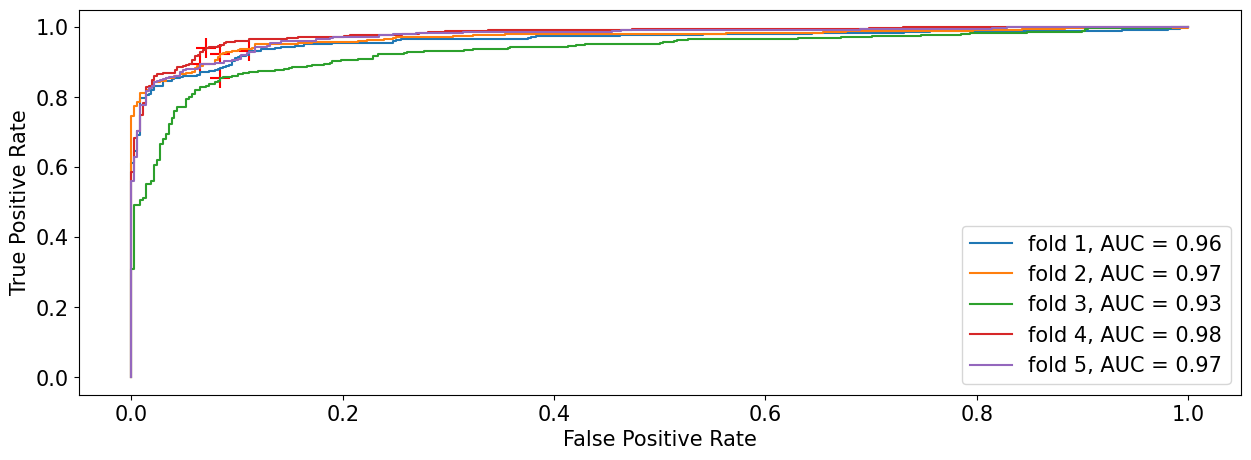

------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 91.12542734441773 (+- 1.7104983606813267)


In [7]:
plt.rc('font', size=15)
plt.figure(figsize=(15,5))

acc_list = []
for fold_no in range(1,6) :
    train_x, train_y, test_x, test_y = load_data(fold_no)
    
    clf = LogisticRegression(C=0.01, penalty='l2')
    clf.fit(train_x, train_y)
    
    y_prob = clf.predict_proba(test_x) 
    y_pred = clf.predict(test_x)

    fpr, tpr, thresholds = roc_curve(test_y, y_prob[:,1])
    auc_value = auc(fpr, tpr)

    optimal_idx = np.argmax(tpr-fpr)
    optimal_trhd = thresholds[optimal_idx]
    sens, spec = tpr[optimal_idx], 1-fpr[optimal_idx]
    
    y_pred_opt = classification_optimal_thres(y_prob[:,1], optimal_trhd)
    acc_list.append(accuracy_score(list(test_y), y_pred_opt)*100)
    
    print("----- Fold {} ------".format(fold_no))
    print("AUC: ", auc_value)
    print("Accuracy: "+str(accuracy_score(list(test_y), y_pred_opt)))
    print('\n')
    print(classification_report(test_y, y_pred_opt, target_names=['non-smile', 'smile']))
    
    plt.plot(fpr, tpr, label='fold {}, AUC = {:.2f}'.format(fold_no
                                                            , roc_auc_score(y_true=test_y, y_score=y_prob[:,1])))
    plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='+', s=200, color='r')
    
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_list)} (+- {np.std(acc_list)})')

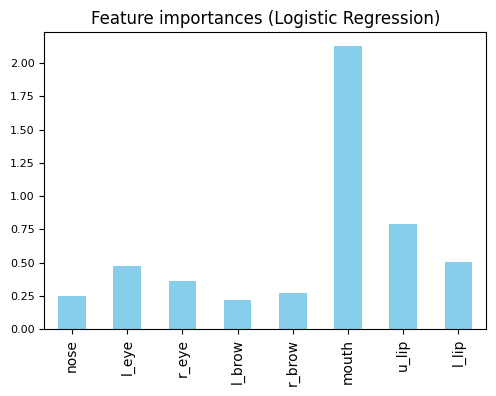

In [5]:
target_fold_no = 4
feature_names = ['nose', 'l_eye', 'r_eye', 'l_brow', 'r_brow', 'mouth', 'u_lip', 'l_lip']
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


for fold_no in range(1,6) :
    if fold_no == 4 :
        train_x, train_y, test_x, test_y = load_data(fold_no)

        clf = LogisticRegression(C=0.01, penalty='l2')
        clf.fit(train_x, train_y)
        
        coef = clf.coef_.ravel()
        _importances = pd.Series(coef, index=feature_names)

        fig, ax = plt.subplots(figsize=(5, 4))
        _importances.plot.bar(ax=ax, color='skyblue')
        ax.set_title("Feature importances (Logistic Regression)")
        fig.tight_layout()
        